In [1]:
import os
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd

from pcg_stein.registry import PRECON_REGISTRY
from pcg_stein.util import make_main_plot

import seaborn as sns


import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

os.getcwd()

'/home/matth/dev/python/jax/pcg_stein/experiments/fig1_experiment'

#### Load Data and Define Metrics

In [2]:
path = os.path.join('results', 'fig1.csv')
results = pd.read_csv(path)

In [3]:
import yaml

with open('experiment.yaml') as f:
    cfg = yaml.safe_load(f)

lengthscale_labels = cfg['ln_lengthscales']
nugget_labels = cfg['ln_nuggets']
block_labels = cfg["block_sizes"]

labels = {
    'lengthscale_labels': lengthscale_labels,
    'nugget_labels': nugget_labels,
    'block_labels': block_labels
}

results["gain"] = np.log(results["m_cg"] + 1) - np.log(results["m_pcg"]  + 1) # defining gain
results["diff"] = results["m_cg"] - results["m_pcg"] # defining the raw difference


### Create Figures and Save

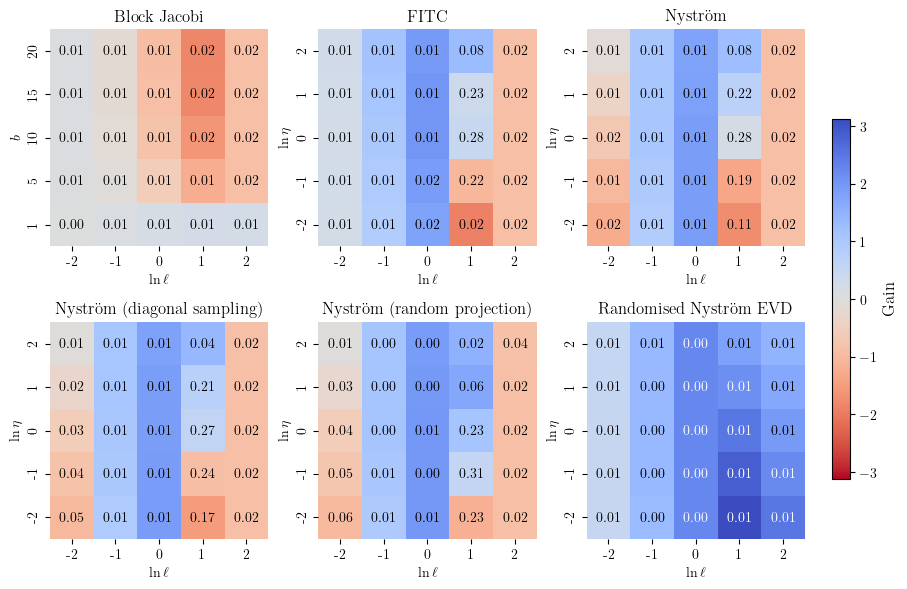

In [ ]:
fig1, _ = make_main_plot(results, labels, metric="gain", cbar_label="Gain")

fig1.savefig(
    "figs/fig1.pdf",  
    format="pdf",     
    bbox_inches="tight",  
    pad_inches=0          
)

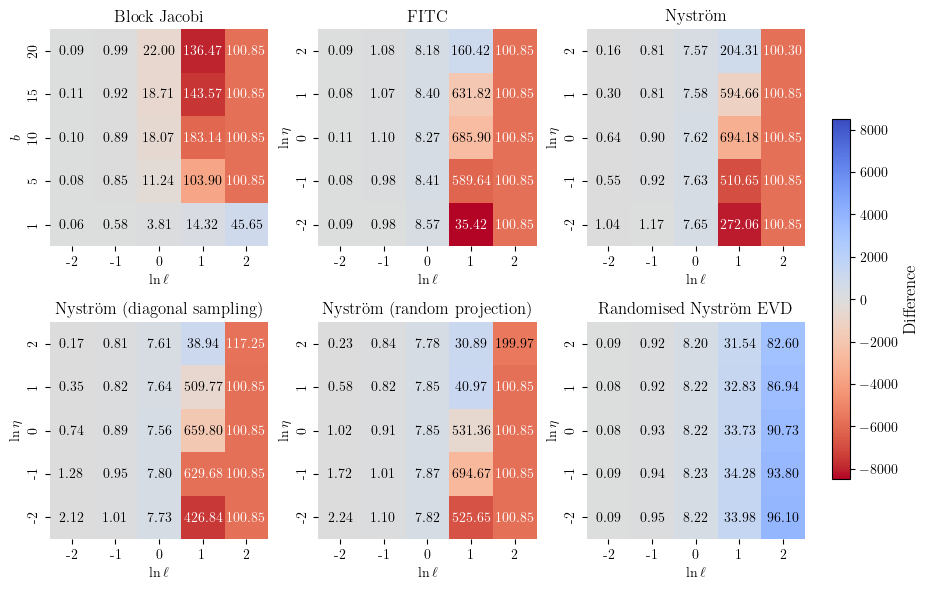

In [ ]:
fig1_diff, _ = make_main_plot(results, labels, metric="diff", cbar_label="Difference")

fig1_diff.savefig(
    "figs/fig1_diff.pdf",    
    format="pdf",         
    bbox_inches="tight", 
    pad_inches=0          
)